In [1]:
!unzip /content/fashion-mnist.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: fashion-mnist/test/0/3745.png  
  inflating: fashion-mnist/test/0/2639.png  
  inflating: fashion-mnist/test/0/1640.png  
  inflating: fashion-mnist/test/0/2389.png  
  inflating: fashion-mnist/test/0/4492.png  
  inflating: fashion-mnist/test/0/5374.png  
  inflating: fashion-mnist/test/0/5397.png  
  inflating: fashion-mnist/test/0/4424.png  
  inflating: fashion-mnist/test/0/640.png  
  inflating: fashion-mnist/test/0/2423.png  
  inflating: fashion-mnist/test/0/444.png  
  inflating: fashion-mnist/test/0/965.png  
  inflating: fashion-mnist/test/0/1460.png  
  inflating: fashion-mnist/test/0/3440.png  
  inflating: fashion-mnist/test/0/2795.png  
  inflating: fashion-mnist/test/0/2474.png  
  inflating: fashion-mnist/test/0/169.png  
  inflating: fashion-mnist/test/0/1647.png  
  inflating: fashion-mnist/test/0/2121.png  
  inflating: fashion-mnist/test/0/2163.png  
  inflating: fashion-mnist/test/0/2753.png 

In [3]:
from glob import glob

train_files = glob('./fashion-mnist/train/*/*.png')
valid_files = glob('./fashion-mnist/valid/*/*.png')
test_files = glob('./fashion-mnist/test/*/*.png')

#--- Ordenamos los datos de forma aleatoria para evitar sesgos
import numpy as np

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)
#Usamos 20% de datos para evitar fallos de ram
train_files = train_files[:int(len(train_files)*0.15)]
valid_files = valid_files[:int(len(valid_files)*0.15)]
test_files = test_files[:int(len(test_files)*0.15)]

In [4]:
import torchvision.transforms as transforms

#--- Transformamos los datos para adaptarlos a la entrada de ResNet 224x224 px
data_transform = transforms.Compose([
                 transforms.Resize((224, 224)),
                 transforms.Grayscale(3), #Dado que MNIST tiene un solo canal, lo cambiamos a 3 para no tener que modificar más capas en el modelo
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                 ])

In [5]:

#--- Cargamos los datos de entrenamiento en listas
from PIL import Image

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append( np.array(data_transform(Image.open(train_file) )))

In [6]:
#--- Cargamos los datos de testeo en listas
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(data_transform(Image.open(test_file)) ))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


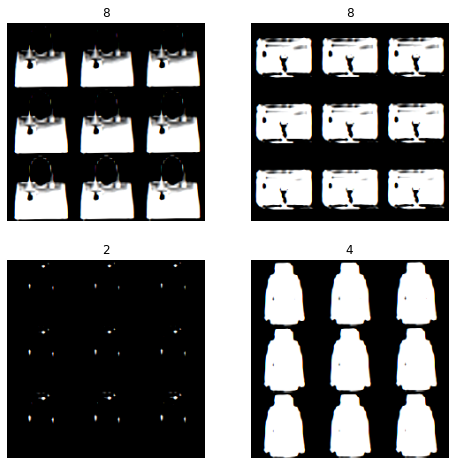

In [7]:
#-- Visualizamos los datos
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15].reshape(224,224,3))
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [8]:
#--- Convetimos las listas con los datos a tensores de torch
import torch
from torch.autograd import Variable

X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([8250, 3, 224, 224])

In [9]:
#-- Creamos el DataLoader

batch_size = 32

train_ds = torch.utils.data.TensorDataset(X_train, Y_train)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [10]:
#--- Seleccionamos y cargamos el modelo, explicación del porque usar este modelo al final del cuaderno
import torch

model = torch.hub.load('pytorch/vision', 'resnet18', pretrained=True)
model

Downloading: "https://github.com/pytorch/vision/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
#--- Congelamos los pesos en las capaz del modelo para que no se actualicen
for p in model.parameters():
    p.requires_grad = False

#--- Definimos el número de clases
out_dim = 10

#--- Reescribimos la nueva capa de salida con el nuevo dataset
model.fc = torch.nn.Sequential(
  torch.nn.Linear(model.fc.in_features, out_dim)
)


model.load_state_dict(model.state_dict())

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:

!pip install hiddenlayer


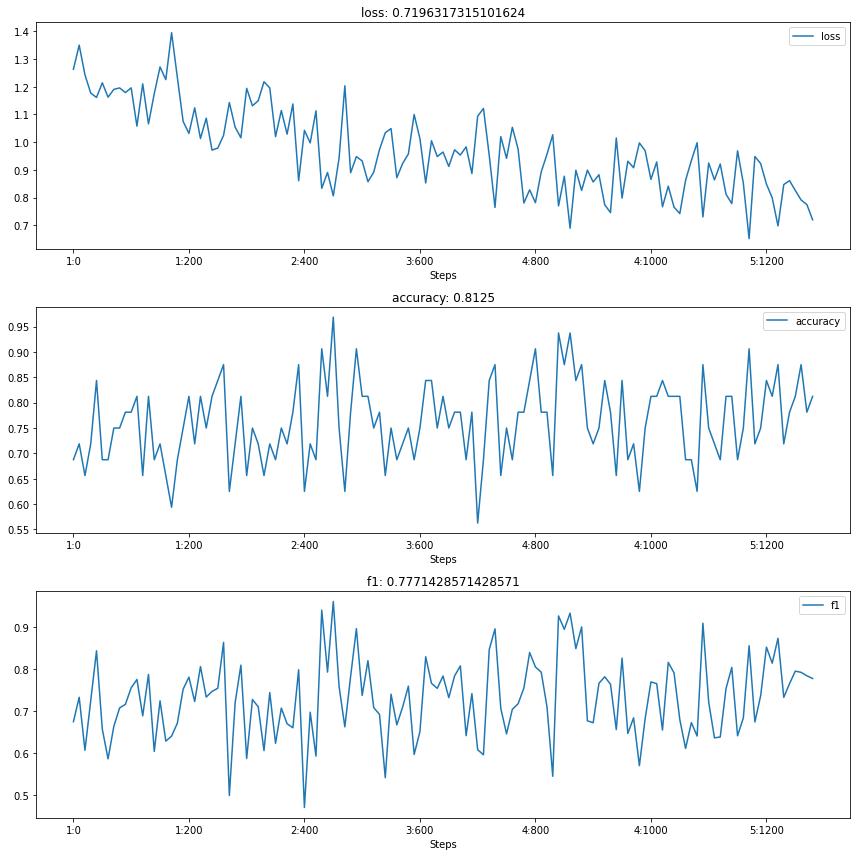

In [21]:
from sklearn.metrics import f1_score
#--- Creamos variables para almacenar los scores en cada época 

model = model.cuda()

model.train()

#--- Definimos nuestro criterio de evaluación y el optimizador 
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.1)
criterion = torch.nn.CrossEntropyLoss()


#--- Entrenamos el modelo usando únicamente 5 épocas
n_epochs = 5

history = hl.History()
canvas = hl.Canvas()

iter = 0

for epoch in range(n_epochs):
  for batch_idx, (X_train_batch, Y_train_batch) in enumerate(train_dl):
    # Pasamos os datos a 'cuda'
    
    X_train_batch = X_train_batch.cuda()
    Y_train_batch = Y_train_batch.cuda()

    # Realiza una predicción
    Y_pred = model(X_train_batch)

    # Calcula el loss
    loss = criterion(Y_pred, Y_train_batch)

    Y_pred = torch.argmax(Y_pred, 1)

    # Calcula el accuracy
    acc = sum(Y_train_batch == Y_pred)/len(Y_pred)
    #-- Calculamos el f1 en la cpu
    f1 = f1_score(Y_train_batch.cpu(),Y_pred.cpu(), average='macro')

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if iter%10 == 0:
        #-- Visualizamos la evolución de los score loss y accuracy
        history.log((epoch+1, iter), loss=loss, accuracy=acc,f1=f1)
        with canvas:
          canvas.draw_plot(history["loss"])
          canvas.draw_plot(history["accuracy"])
          canvas.draw_plot(history["f1"])

    iter += 1
    del X_train_batch, Y_train_batch, Y_pred

In [32]:
#-- Testeamos el modelo

X_test, Y_test = X_test.cuda(), Y_test.cuda()
model.eval()
Xvl = X_test
Y_pred = model(Xvl)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test.cpu(), Y_pred.cpu(), average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print( 'Loss:{:.2f}, F1:{:.2f}, Acc:{:.2f}'.format(loss.item(), f1, acc ) )

Loss:0.81, F1:0.77, Acc:0.77


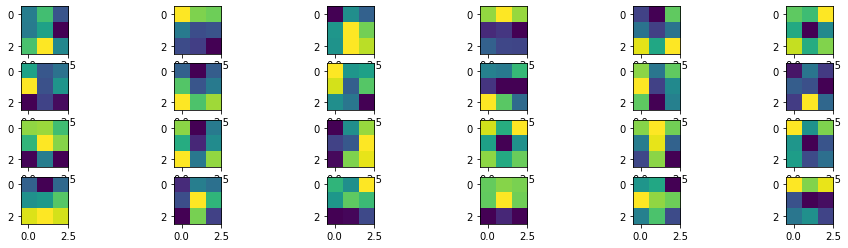

In [93]:
#-- Visualizando los mapas de características de la primera capa convolucional
kernels = list(model.children())[7][1].conv2.weight.detach()
kernels = kernels.cpu()
fig = plt.figure(figsize=(16,4))
k = 0
#Solo se muestran 24, porque habrían 512 mapas
for i in range(kernels.size(0)-488):
    plt.subplot(4,6,k+1)
    plt.imshow(kernels[i][0])
    k += 1
plt.show()

In [94]:
from sklearn.metrics import confusion_matrix

def CM(Y_true, Y_pred, classes):
  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true, Y_pred)
  lclasses = np.arange(0,classes)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

  plt.show()

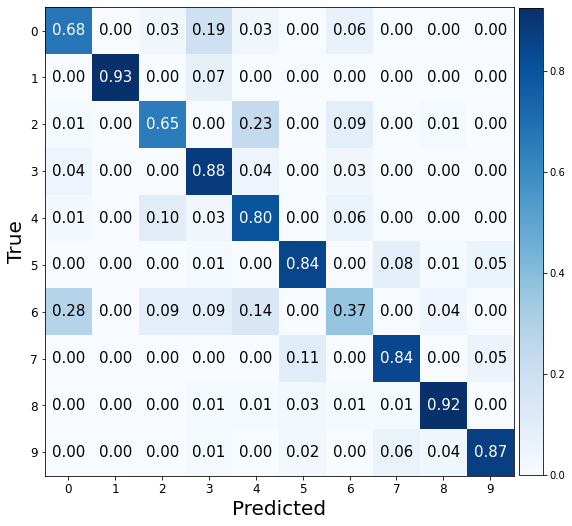

In [95]:

CM(Y_test.cpu(), Y_pred.cpu(), 10)

#Mi red neuronal parte de la red neuronal resnet, ya que esta está mejor optimizada ya que permite parar la red por bloques para mejorar el aprendizaje, se cambió la última capa para acomodarse al output que exige este set de datos (10 clases). En cuanto a los resultados no se obtuvieron buenos valores de loss, accuracy y f1, pero eso se debió a que solo se pudo usar el 15% de los datos por problemas de memoria ram, sin embargo se alcanza a apreciar un buen aprendizaje del modelo sobretodo a través de la matriz de confusión.